In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import datetime

In [110]:
df_price = pd.read_csv(os.path.join('005930.KS.csv'), encoding='utf8')
df_price.describe()
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-03,25900.0,25940.0,25720.0,25800.0,260.387482,8334750.0
1,2015-12-04,25500.0,25600.0,25340.0,25380.0,256.148621,9635550.0
2,2015-12-07,25380.0,25500.0,25240.0,25240.0,254.735657,9805350.0
3,2015-12-08,25240.0,25440.0,25240.0,25240.0,254.735657,6916100.0
4,2015-12-09,25240.0,25500.0,25240.0,25260.0,254.937500,9090600.0


In [111]:
df_price = df_price.dropna()    #nan 결측치 제거

In [112]:
from sklearn.preprocessing import MinMaxScaler      #데이터 정규화 도구

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df_price[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close    Volume
0     0.088765  0.069433  0.085088  0.069817  0.128859
1     0.080189  0.062235  0.076923  0.060877  0.148970
2     0.077616  0.060119  0.074774  0.057897  0.151595
3     0.074614  0.058848  0.074774  0.057897  0.106926
4     0.074614  0.060119  0.074774  0.058323  0.140544
...        ...       ...       ...       ...       ...
1215  0.950686  0.959780  0.950580  0.968072  0.294109
1216  0.991424  0.968247  0.984959  0.972329  0.217427
1217  1.000000  0.972481  0.965621  0.940400  0.677337
1218  0.972127  0.966130  0.974216  0.963814  0.345187
1219  1.000000  1.000000  1.000000  1.000000  0.429767

[1220 rows x 5 columns]


In [113]:
train = df_scaled[:-300]
test = df_scaled[-300:]     #최근 데이터에서 300일치 데이터만큼을 test set으로 이용

In [114]:
def make_dataset(data, label, window_size=50):      #윈도우 생성 과정 함수화
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [115]:
feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']
#train, test 모델 데이터생성

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((280, 20, 4), (280, 1))

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, input_shape=(20,4), activation='relu', return_sequences=False))
model.add(Dense(1))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 16)                1344      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [120]:
model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5) #overfitting 방지, 같은 오차가 5번나오면 훈련중지
filename = os.path.join('tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/20
33/45 [=====================>........] - ETA: 0s - loss: 4.9539e-04
Epoch 00001: val_loss improved from inf to 0.00051, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 9ms/step - loss: 4.9159e-04 - val_loss: 5.1076e-04
Epoch 2/20
39/45 [=========================>....] - ETA: 0s - loss: 4.6577e-04
Epoch 00002: val_loss improved from 0.00051 to 0.00043, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 5ms/step - loss: 4.7458e-04 - val_loss: 4.2561e-04
Epoch 3/20
38/45 [========================>.....] - ETA: 0s - loss: 4.7162e-04
Epoch 00003: val_loss did not improve from 0.00043
45/45 [==============================] - 0s 5ms/step - loss: 4.7373e-04 - val_loss: 6.0119e-04
Epoch 4/20
39/45 [=========================>....] - ETA: 0s - loss: 5.4718e-04
Epoch 00004: val_loss improved from 0.00043 to 0.00041, saving model to tmp_checkpoint.h5
45/45 [==============================] - 0s 5ms/step - loss: 5.3600e-04 - val_loss

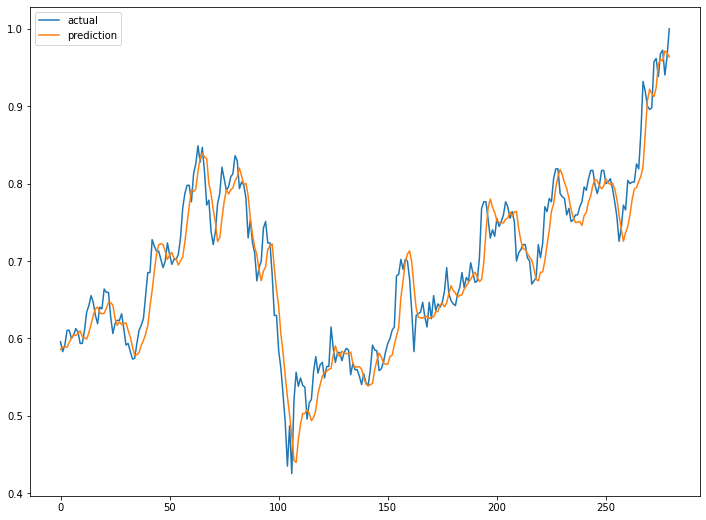

In [121]:
model.load_weights(filename)
pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()